In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchdiffeq import odeint
import matplotlib.pyplot as plt

In [2]:
# Define the ODE function using a neural network
class NeuralODE(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NeuralODE, self).__init__()
        # Define the neural network (ODE function)
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)  # Output dimension set to 6
        )

    def forward(self, t, y):
        # y is the state vector, which has a size of [batch_size, input_dim]
        return self.net(y)  # Return the ODE function

# Define a model to reduce the input dimension
class DimensionalityReduction(nn.Module):
    def __init__(self):
        super(DimensionalityReduction, self).__init__()
        # Global average pooling to reduce input from 100 timesteps to 1 timestep
        self.pool = nn.AdaptiveAvgPool1d(1)

    def forward(self, x):
        # x is of shape [batch_size, 100, 6]
        x = x.permute(0, 2, 1)  # Permute to [batch_size, 6, 100]
        x = self.pool(x)  # Apply adaptive pooling to reduce timesteps from 100 to 1
        return x.squeeze(-1)  # Squeeze to get shape [batch_size, 6]

# Example ODE Model
class ODEModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ODEModel, self).__init__()
        self.dimensionality_reduction = DimensionalityReduction()
        self.neural_ode = NeuralODE(input_dim, hidden_dim, output_dim)

    def forward(self, x0, t_span):
        # Apply dimensionality reduction to the input
        x0 = self.dimensionality_reduction(x0)  # Now x0 is of shape [batch_size, 6]
        y = odeint(self.neural_ode, x0, t_span)

        # Solve ODE from t=0 to t=end using odeint
        return y[-1]

# Example Usage
input_dim = 6  # After dimensionality reduction, the input dimension becomes 6
hidden_dim = 50
output_dim = 6  # 6 output features

# Create Neural ODE Model
model = ODEModel(input_dim, hidden_dim, output_dim)

# Initial condition (batch_size=1, 100 timesteps, 6 input features)
x0 = torch.randn(901, 100, 6)  # Random 1x100x6 input
print(x0.shape)
# Time range from 0 to 1
t_span = torch.linspace(0., 1.01, 102)  # Time steps

# Get the output from Neural ODE
output = model(x0, t_span)

torch.Size([901, 100, 6])


In [3]:
# Load the data from the txt file with the correct data type
data = np.loadtxt('data_train.txt', delimiter=',', dtype=np.float32)

window_size = 100

# Reshape the inputs to (num_samples, 100, 6)
# Assuming each row is a time step with 7 columns: 1 for time and 6 for the states

time_steps = len(data)  # The total number of time steps (rows in data)
state_size = 6          # Number of state variables per time step (columns 2 to 7)

# Initialize the arrays for input and output data
input_data = np.zeros((time_steps - window_size, window_size, state_size))  # (num_samples, 100, 6)
output_data = np.zeros((time_steps - window_size, state_size))      # (num_samples, 6)

# Loop to create time-series inputs and outputs
for i in range(time_steps - window_size):
    input_data[i] = data[i:i + window_size, 1:7]  # Inputs: columns 2 to 7 for 100 time steps
    output_data[i] = data[i + window_size, 1:7]  # Output: columns 2 to 7 for the state at time t+100

# Convert to torch tensors
inputs_tensor = torch.tensor(input_data, dtype=torch.float32)
outputs_tensor = torch.tensor(output_data, dtype=torch.float32)

/tmp/ipykernel_117582/1791876448.py:13: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.subplot(2, 3, i + 1)


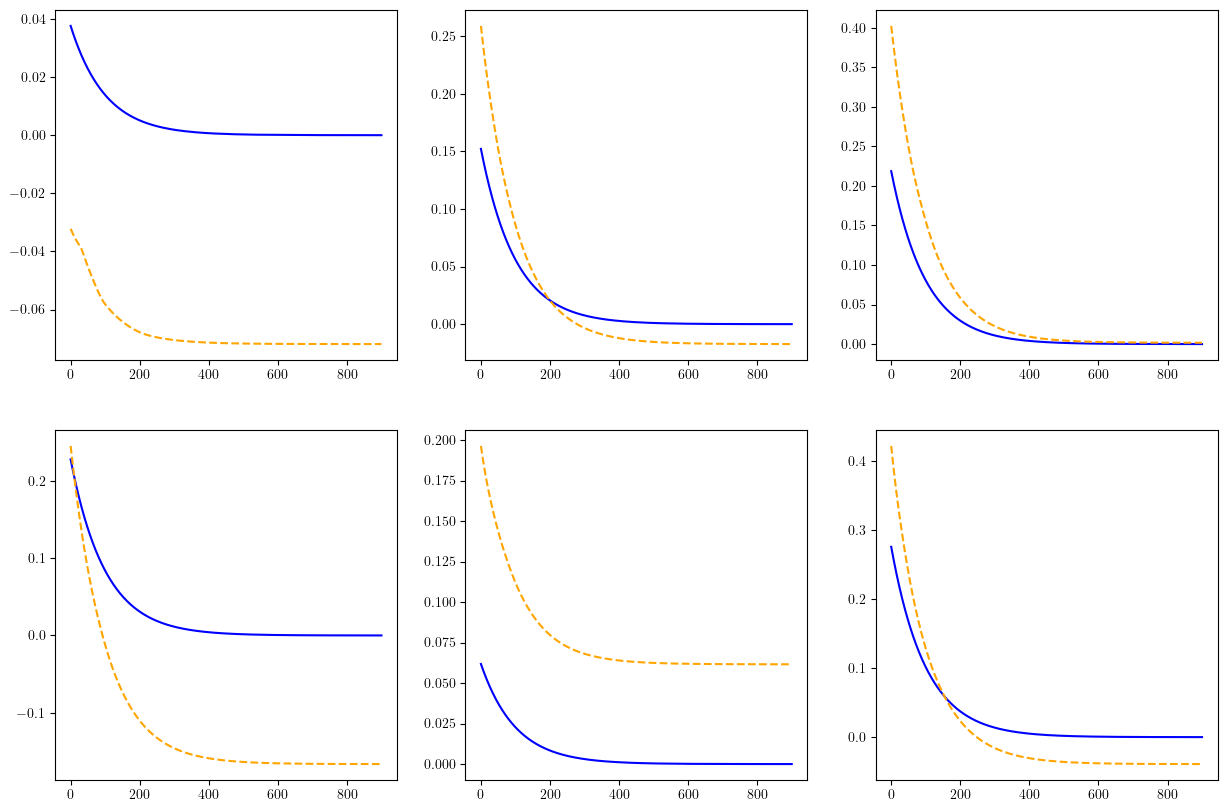

In [4]:
# Convert predictions and targets to numpy for easier plotting
output = model(inputs_tensor, t_span)
predicted_values = output.detach().numpy()  # Model predictions
true_values = output_data  # True target values from the dataset

# Plot each output feature over the sample indices
num_features = predicted_values.shape[1]
sample_indices = range(len(predicted_values))  # X-axis

plt.figure(figsize=(15, 10))

for i in range(num_features):
    plt.subplot(2, 3, i + 1)
    plt.plot(sample_indices, true_values[:, i], label="True", color="blue")
    plt.plot(sample_indices, predicted_values[:, i], label="Predicted", color="orange", linestyle="--")
    # plt.xlabel("Sample index")
    # plt.ylabel(f"Feature {i + 1}")
    # plt.legend()
    # plt.title(f"Output Feature {i + 1}")

# plt.tight_layout()
plt.show()

In [5]:
# Training loop
epochs = 500

criterion = nn.MSELoss()  # Mean squared error loss for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass: Get the model output
    output = model(inputs_tensor, t_span)

    # Compute loss: Compare output to target
    loss = criterion(output, outputs_tensor)

    # Backward pass: Compute gradients
    loss.backward()

    # Update the model parameters
    optimizer.step()

    # Print loss every 100 epochs
    if epoch % 10 == 0:
        print(f"Epoch [{epoch}/{epochs}], Loss: {loss.item()}")


Epoch [0/500], Loss: 0.006245981901884079
Epoch [10/500], Loss: 0.0011841385858133435
Epoch [20/500], Loss: 0.0007169859018176794
Epoch [30/500], Loss: 0.00047306594206020236
Epoch [40/500], Loss: 0.000250634562689811
Epoch [50/500], Loss: 0.00013467753888107836
Epoch [60/500], Loss: 4.460472700884566e-05
Epoch [70/500], Loss: 1.1624069884419441e-05
Epoch [80/500], Loss: 3.5933987874159357e-06
Epoch [90/500], Loss: 1.8410635220789118e-06
Epoch [100/500], Loss: 9.82156507234322e-07
Epoch [110/500], Loss: 5.009811729905778e-07
Epoch [120/500], Loss: 3.790044900142675e-07
Epoch [130/500], Loss: 3.4069535104208626e-07
Epoch [140/500], Loss: 3.0169448450578784e-07
Epoch [150/500], Loss: 2.7204362140764715e-07
Epoch [160/500], Loss: 2.495118849310529e-07
Epoch [170/500], Loss: 2.307320841055116e-07
Epoch [180/500], Loss: 2.1442507147639844e-07
Epoch [190/500], Loss: 1.9967242792517936e-07
Epoch [200/500], Loss: 1.8624218967033812e-07
Epoch [210/500], Loss: 1.739716850579498e-07
Epoch [220/50

In [19]:
# Convert predictions and targets to numpy for easier plotting
predicted_values = output.detach().numpy()  # Model predictions
true_values = output_data  # True target values from the dataset

# Plot each output feature over the sample indices
num_features = predicted_values.shape[1]
sample_indices = range(len(predicted_values))  # X-axis

plt.figure(figsize=(15, 15))

for i in range(num_features):
    plt.subplot(2, 3, i + 1)  # Create a subplot for each feature
    plt.plot(sample_indices, true_values[:, i], label="True", color="blue")
    plt.plot(predicted_values[:, 1], label="Predicted", color="orange", linestyle="--")

plt.tight_layout()
plt.show()


/tmp/ipykernel_117582/1168226235.py:12: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.subplot(2, 3, i + 1)  # Create a subplot for each feature


RuntimeError: latex was not able to process the following string:
b'$\\\\mathdefault{0.16}$'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmp1yigelx8 b0f423b4ae3d87ff64f3f57d29e7b975.tex

This is pdfTeX, Version 3.14159265-2.6-1.40.20 (TeX Live 2019/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./b0f423b4ae3d87ff64f3f57d29e7b975.tex
LaTeX2e <2020-02-02> patch level 2
L3 programming layer <2020-02-14>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2019/12/20 v1.4l Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))

! LaTeX Error: File `type1cm.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.7 \usepackage
               {type1ec}^^M
No pages of output.
Transcript written on tmp1yigelx8/b0f423b4ae3d87ff64f3f57d29e7b975.log.




<Figure size 1500x1500 with 6 Axes>

(901,)
(901,)
range(0, 901)


/tmp/ipykernel_114194/2162261840.py:41: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.plot(sample_indices, predicted_values[:, 0])


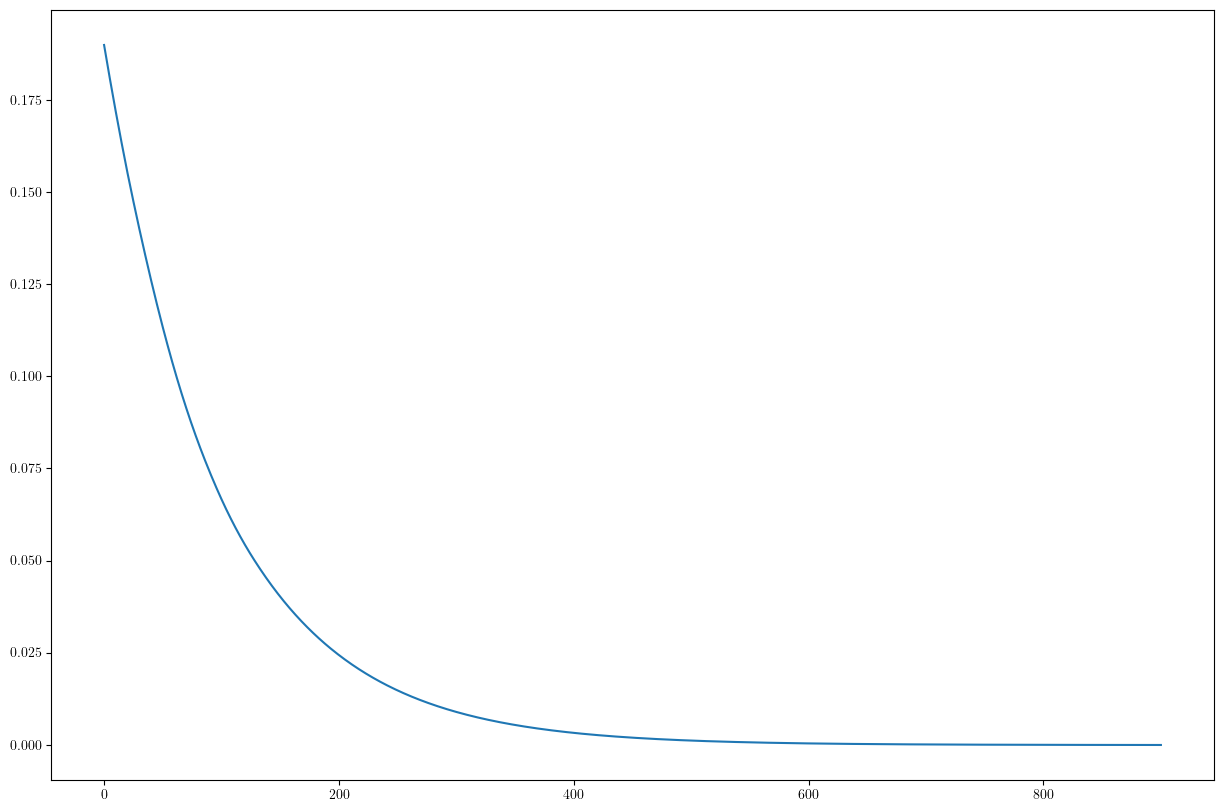

(901, 6)

In [ ]:
# Load the data from the txt file with the correct data type
data = np.loadtxt('data_test.txt', delimiter=',', dtype=np.float32)

window_size = 100

time_steps = len(data)  # The total number of time steps (rows in data)
state_size = 6          # Number of state variables per time step (columns 2 to 7)

# Initialize the arrays for input and output data
input_data = np.zeros((time_steps - window_size, window_size, state_size))  # (num_samples, 100, 6)
output_data = np.zeros((time_steps - window_size, state_size))      # (num_samples, 6)

# Loop to create time-series inputs and outputs
for i in range(time_steps - window_size):
    input_data[i] = data[i:i + window_size, 1:7]  # Inputs: columns 2 to 7 for 100 time steps
    output_data[i] = data[i + window_size, 1:7]  # Output: columns 2 to 7 for the state at time t+100

# Convert to torch tensors
inputs_tensor = torch.tensor(input_data, dtype=torch.float32)
outputs_tensor = torch.tensor(output_data, dtype=torch.float32)

# Convert predictions and targets to numpy for easier plotting
output = model(inputs_tensor, t_span)
predicted_values = output.detach().numpy()  # Model predictions
true_values = output_data  # True target values from the dataset

# Plot each output feature over the sample indices
num_features = predicted_values.shape[1]
sample_indices = range(len(predicted_values))  # X-axis

plt.figure(figsize=(15, 10))


i = 1

print(predicted_values[:,i].shape)
print(true_values[:, i].shape)
print(sample_indices)

# plt.plot(sample_indices, true_values[:, i], label="True", color="blue")
plt.plot(sample_indices, predicted_values[:, 0])

# for i in range(num_features):
#     plt.subplot(2, 3, i + 1)  # Create a subplot for each feature
#     plt.plot(sample_indices, true_values[:, i], label="True", color="blue")
#     plt.plot(sample_indices, predicted_values[:, i], label="Predicted", color="orange")

plt.show()

predicted_values.shape


